In [64]:
import os
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import kerastuner as kt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback, ModelCheckpoint
from sklearn.metrics import confusion_matrix

In [21]:
path_current = os.getcwd()
path = os.path.dirname(path_current)
path = os.path.join(path, 'app', 'files')

In [60]:
train_dir = f'{path}/Brain Tumor MRI/train'
test_dir = f'{path}/Brain Tumor MRI/test'
predict_dir = f'{path}/Brain Tumor MRI/predict'

In [ ]:
train_datage = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
predict_dir = ImageDataGenerator(rescale=1./255)

In [37]:
train_generator = train_datage.flow_from_directory(
    train_dir,
    target_size=(124, 124),
    batch_size=128,
    class_mode='categorical',
    color_mode='grayscale',
    subset = 'training'
)

Found 5712 images belonging to 4 classes.


In [38]:
validation_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(124, 124),
    batch_size=128,
    class_mode='categorical',
    color_mode='grayscale',
    subset = 'validation'
)

Found 262 images belonging to 4 classes.


In [39]:
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(124, 124),
    batch_size=128,
    class_mode='categorical',
    color_mode='grayscale',
)

Found 1311 images belonging to 4 classes.


In [61]:
predict_generator = test_datagen.flow_from_directory(
    predict_dir,
    target_size=(124, 124),
    batch_size=128,
    class_mode='categorical',
    color_mode='grayscale',
)

Found 16 images belonging to 1 classes.


In [40]:
classes = ["glioma", "meningioma", "notumor", "pituitary"]

In [29]:
def plotImages(img_arr):
    fig, axes = plt.subplots(1,5, figsize=(10,10))
    axes = axes.flatten()
    for img, ax in zip(img_arr, axes):
        ax.imshow(img[:,:,0])
        ax.axis('off')
    plt.tight_layout()
    plt.show()

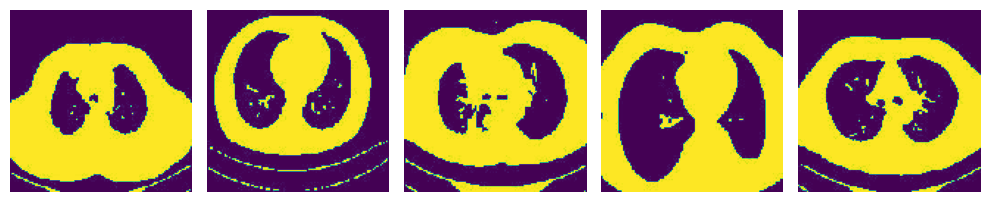

In [30]:
sample_training_images, _ = next(train_generator)
plotImages(sample_training_images[:5])

### Primer modelo (sin capas convolucionadas)

In [45]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(124, 124, 1)),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(126, activation='relu'),
    tf.keras.layers.Dense(len(classes), activation='softmax')
])

e:\Programacion\IA\CNN\tf_gpu_env\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [46]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)             │ (None, 15376)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │     3,936,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 126)            │        32,382 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │           381 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,969,275 (15.14 MB)

 Trainable params: 3,969,275 (15.14 MB)

 Non-trainable params: 0 (0.00 B)

In [47]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

hist = model.fit(train_generator, epochs=10, validation_data=validation_generator)

e:\Programacion\IA\CNN\tf_gpu_env\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 11s 420ms/step - accuracy: 0.4087 - loss: 5.0953 - val_accuracy: 0.6429 - val_loss: 2.6096
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 105ms/step - accuracy: 0.5089 - loss: 1.9317 - val_accuracy: 0.6071 - val_loss: 1.5055
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step - accuracy: 0.7428 - loss: 0.6662 - val_accuracy: 0.5000 - val_loss: 1.8677
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step - accuracy: 0.8017 - loss: 0.5021 - val_accuracy: 0.6071 - val_loss: 1.8305
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 0.8640 - loss: 0.3418 - val_accuracy: 0.6429 - val_loss: 1.6273
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 105ms/step - accuracy: 0.9466 - loss: 0.1929 - val_accuracy: 0.6071 - val_loss: 1.8686
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step - accuracy: 0.9727 - loss: 0.1201 - val_accuracy: 0.6429 - val_loss: 1.7763
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - accuracy: 0.9822 - loss: 0.0912 - val_accuracy: 0.6429 - val_loss

#### Resultado del modelo (primer modelo)

In [48]:
results = model.evaluate(test_generator)

e:\Programacion\IA\CNN\tf_gpu_env\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.5888 - loss: 2.1028 


In [41]:
# Función para visualizar los resultados
def vis_result(hist, e=20):
    epochs = [i for i in range(e)]
    fig, ax = plt.subplots(1,2)
    train_acc = hist.history['accuracy']
    train_loss = hist.history['loss']
    val_acc = hist.history['val_accuracy']
    val_loss = hist.history['val_loss']
    fig.set_size_inches(16, 9)

    ax[0].plot(epochs, train_acc, 'go-', label='Training Accuracy')
    ax[0].plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
    ax[0].set_title('Training & Validation Accuracy')
    ax[0].legend()
    ax[0].set_xlabel("Epochs")
    ax[0].set_ylabel("Accuracy")

    ax[1].plot(epochs, train_loss, 'g-o', label='Training Loss')
    ax[1].plot(epochs, val_loss, 'r-o', label='Validation Loss')
    ax[1].set_title('Training & Validation Loss')
    ax[1].legend()
    ax[1].set_xlabel("Epochs")
    ax[1].set_ylabel("Loss")

    plt.show()

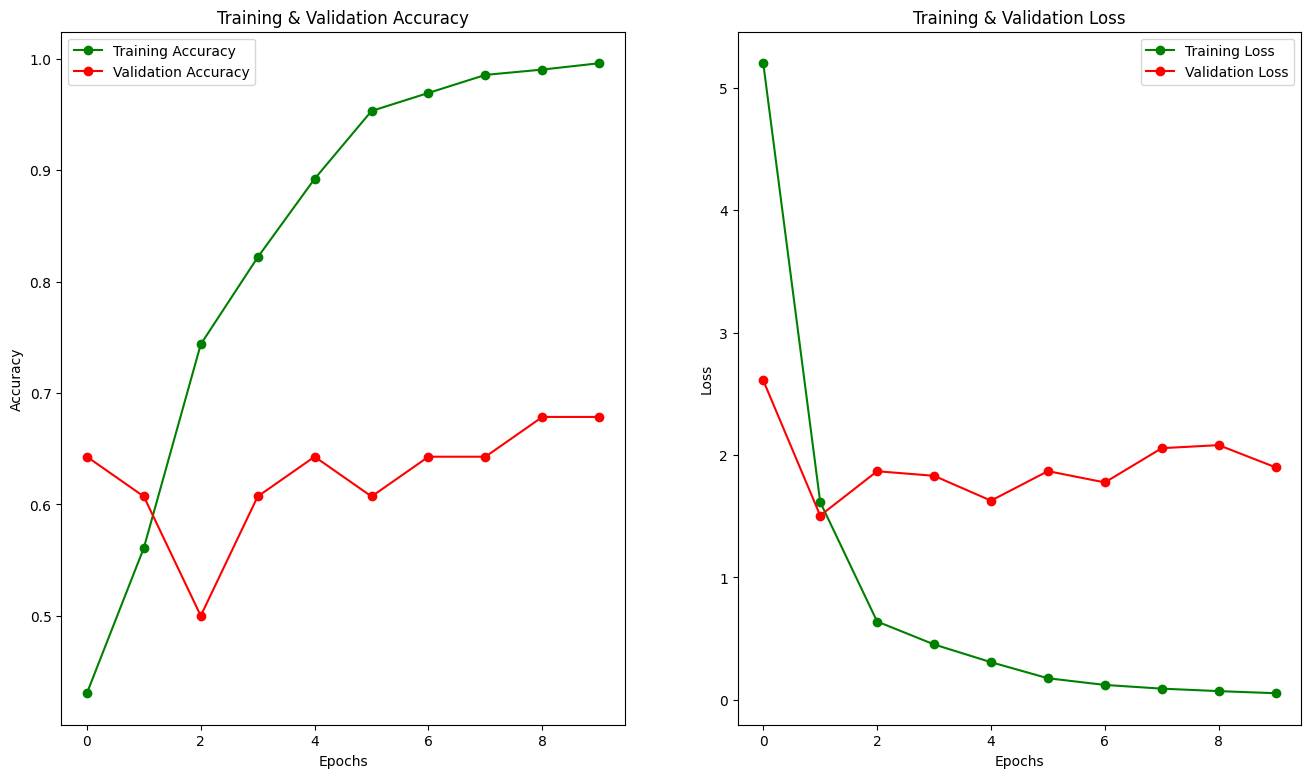

In [50]:
vis_result(hist)

### Segundo modelo (primera iteración, uso de capas para reducir el overfiting y mejorar el val_accuracy)

In [61]:
model_opt = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(124, 124, 1)),
    tf.keras.layers.Dense(256, kernel_regularizer=regularizers.l2(1e-5), activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(126, kernel_regularizer=regularizers.l2(1e-5), activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(len(classes), activation='softmax')
])
model_opt.summary()

e:\Programacion\IA\CNN\tf_gpu_env\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_4 (Flatten)             │ (None, 15376)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 256)            │     3,936,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 126)            │        32,382 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 126)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 3)              │           381 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,969,275 (15.14 MB)

 Trainable params: 3,969,275 (15.14 MB)

 Non-trainable params: 0 (0.00 B)

In [62]:
model_opt.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [63]:
hist_opt = model_opt.fit(train_generator, epochs=20, validation_data=validation_generator)

Epoch 1/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 153ms/step - accuracy: 0.3753 - loss: 5.4134 - val_accuracy: 0.6071 - val_loss: 2.7213
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - accuracy: 0.4542 - loss: 2.6092 - val_accuracy: 0.4286 - val_loss: 1.5441
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - accuracy: 0.5331 - loss: 1.7008 - val_accuracy: 0.6429 - val_loss: 1.0443
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 0.6151 - loss: 0.9932 - val_accuracy: 0.6429 - val_loss: 1.4488
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - accuracy: 0.7508 - loss: 0.5925 - val_accuracy: 0.6429 - val_loss: 1.2567
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - accuracy: 0.8242 - loss: 0.4602 - val_accuracy: 0.6429 - val_loss: 1.2865
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - accuracy: 0.8939 - loss: 0.3280 - val_accuracy: 0.6429 - val_loss: 1.1863
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - accuracy: 0.9145 - loss: 0.2719 - val_accuracy: 0.6429 - val_loss:

#### Resultado del modelo (segundo modelo)

In [66]:
results_opt = model_opt.evaluate(test_generator)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5862 - loss: 2.8757


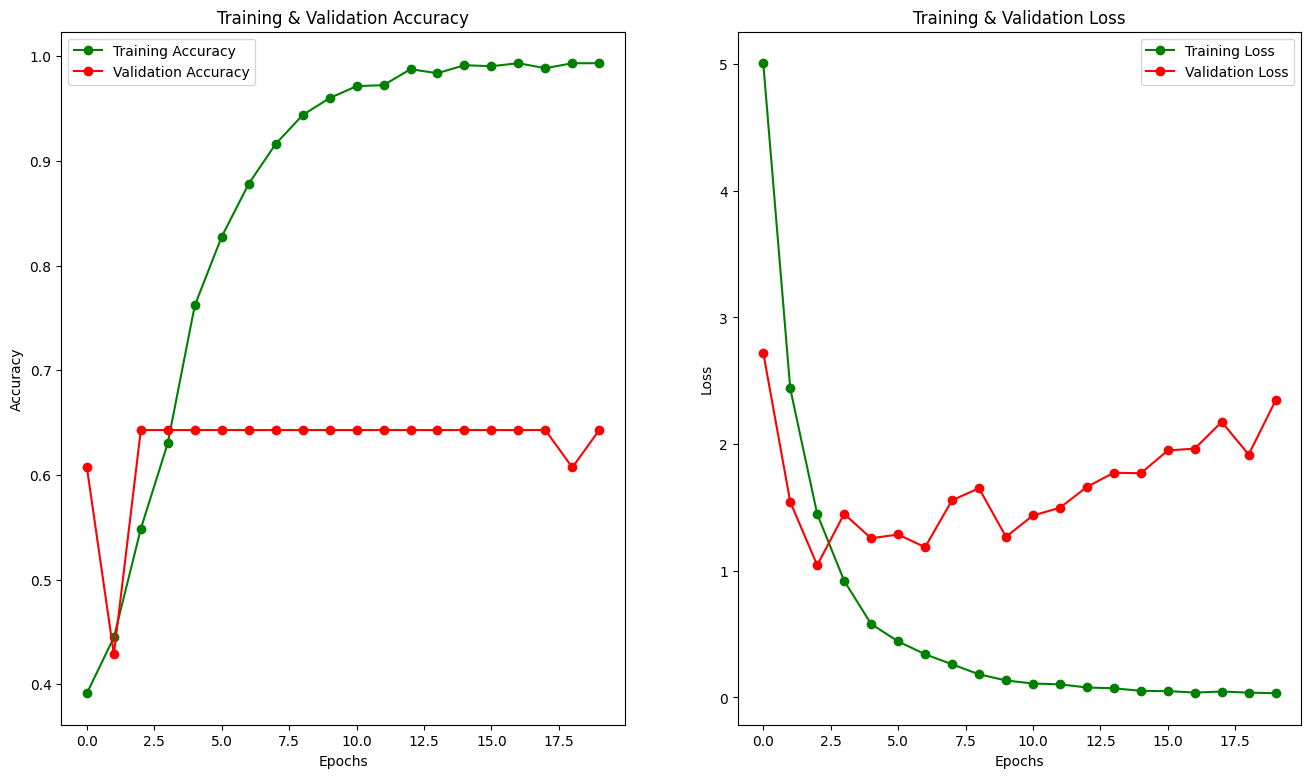

In [69]:
vis_result(hist_opt)

### Tercer modelo (segunda iteración, uso de capa convolucionada y redimencionamiento)

In [70]:
model_opt_conv = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(75, (3,3), activation='relu', input_shape=(124, 124, 1)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, kernel_regularizer=regularizers.l2(1e-5), activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(126, kernel_regularizer=regularizers.l2(1e-5), activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(len(classes), activation='softmax')
])
model_opt_conv.summary()

model_opt_conv.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
hist_opt_conv = model_opt_conv.fit(train_generator, epochs=20, validation_data=validation_generator)

e:\Programacion\IA\CNN\tf_gpu_env\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 122, 122, 75)   │           750 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 61, 61, 75)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 279075)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 256)            │    71,443,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 126)            │        32,382 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 126)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 3)              │           381 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 71,476,969 (272.66 MB)

 Trainable params: 71,476,969 (272.66 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.3690 - loss: 4.7371 - val_accuracy: 0.6071 - val_loss: 1.6858
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - accuracy: 0.5360 - loss: 1.8076 - val_accuracy: 0.5357 - val_loss: 1.6347
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - accuracy: 0.7177 - loss: 0.6498 - val_accuracy: 0.6071 - val_loss: 1.6969
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - accuracy: 0.9070 - loss: 0.2848 - val_accuracy: 0.5357 - val_loss: 2.1531
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - accuracy: 0.9696 - loss: 0.1445 - val_accuracy: 0.6071 - val_loss: 2.8661
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - accuracy: 0.9962 - loss: 0.0658 - val_accuracy: 0.6071 - val_loss: 2.5100
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - accuracy: 0.9933 - loss: 0.0465 - val_accuracy: 0.6429 - val_loss: 2.6179
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - accuracy: 0.9970 - loss: 0.0390 - val_accuracy: 0.6071 - val_loss: 2.5112
Epoch 9/

#### Resultado del modelo (tercer modelo)

In [71]:
results_opt_conv = model_opt_conv.evaluate(test_generator)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - accuracy: 0.6256 - loss: 2.5966


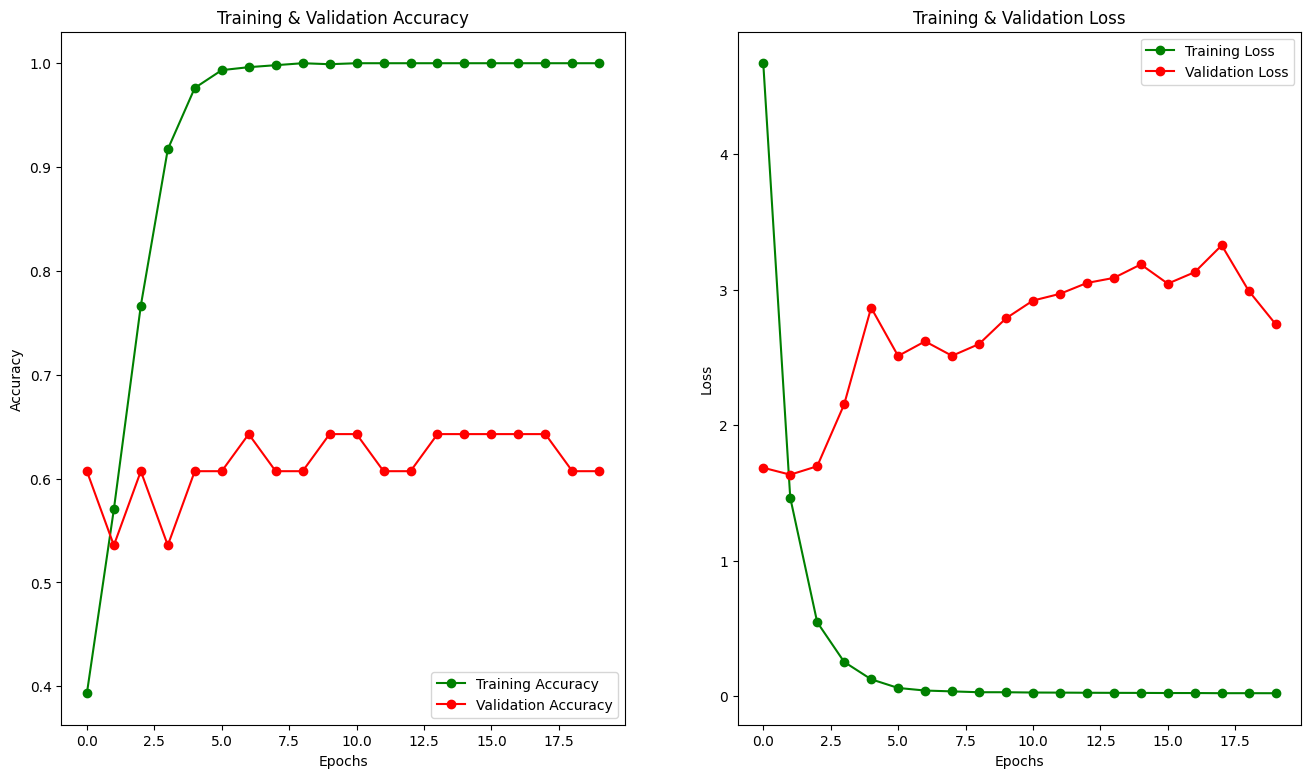

In [73]:
vis_result(hist_opt_conv)

### Creación de funcion para crear modelos para interaciones futuras

In [36]:
def get_model():
    model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(75, (3,3), activation='relu', input_shape=(124, 124, 1)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, kernel_regularizer=regularizers.l2(1e-5), activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(126, kernel_regularizer=regularizers.l2(1e-5), activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(len(classes), activation='softmax')
    ])
    return model

model_opt_conv = get_model()
model_opt_conv.summary()

model_opt_conv.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 122, 122, 75)   │           750 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 61, 61, 75)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 279075)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 256)            │    71,443,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 126)            │        32,382 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 126)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 3)              │           381 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 71,476,969 (272.66 MB)

 Trainable params: 71,476,969 (272.66 MB)

 Non-trainable params: 0 (0.00 B)

### Callback para detener el entrenamiento cuando este llegue a 0.95 de test_acurracy 

In [37]:
class TrainCallback(Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('accuracy') > 0.95:
            print("\nReached 95% accuracy so cancelling training!")
            self.model.stop_training = True

In [ ]:
callback = TrainCallback()

hist_opt_conv = model_opt_conv.fit(train_generator, epochs=20, validation_data=validation_generator, callbacks=[callback])

### Resultados del tercer modelo usando el callback

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.6131 - loss: 1.4532


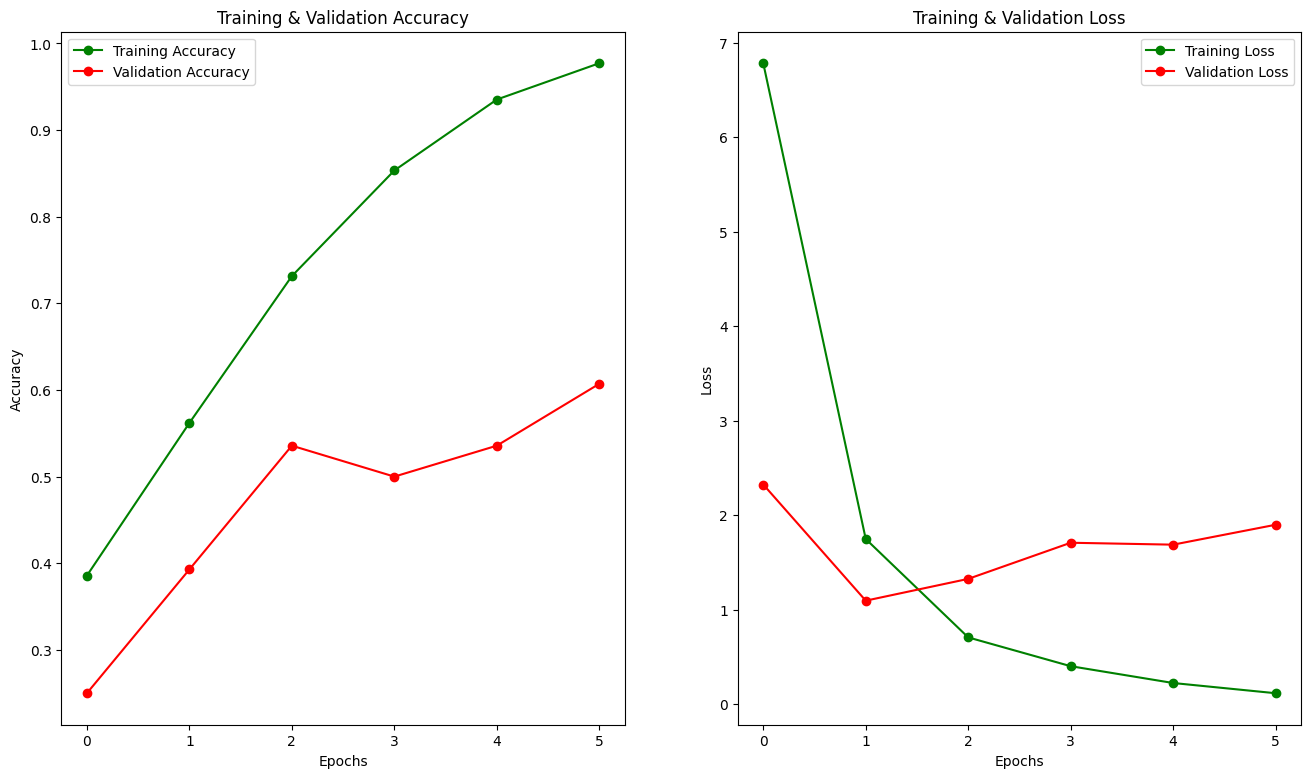

In [17]:
results_opt_conv = model_opt_conv.evaluate(test_generator)
vis_result(hist_opt_conv, e=6)

### Funcion para realicar el tunner (los valores a tunnear son el número de neuronas de la primera capa Dense y el lr del optimizador)

In [72]:
def construct_model(hp):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Conv2D(75, (3,3), activation='relu', input_shape=(124, 124, 1)))
    model.add(tf.keras.layers.MaxPooling2D(2, 2))
    model.add(tf.keras.layers.Flatten())

    hp_units = hp.Int('unit', min_value=32, max_value=512, step=32)

    model.add(tf.keras.layers.Dense(units=hp_units, kernel_regularizer=regularizers.l2(1e-5), activation='relu'))
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Dense(128, kernel_regularizer=regularizers.l2(1e-5), activation='relu'))
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Dense(len(classes), activation='softmax'))

    hp_lr = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    
    model.compile(optimizer=Adam(hp_lr), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [32]:
tunner = kt.Hyperband(
    construct_model,
    objective='val_accuracy',
    max_epochs=10,
    factor=3,
    directory='models/',
    project_name='TumorClassification-tunner'
)

In [23]:
tunner.search(train_generator, epochs=10, validation_data=validation_generator)
best_hps = tunner.get_best_hyperparameters(num_trials=1)[0]

Trial 30 Complete [00h 04m 06s]
val_accuracy: 0.6785714030265808

Best val_accuracy So Far: 0.7142857313156128
Total elapsed time: 00h 46m 27s


### Resultados del tunner

#### Mejor cantidad de neuronas

In [28]:
print(best_hps.get('unit'))

384


#### Mejor learning_rate (lr)

In [29]:
print(best_hps.get('learning_rate'))

0.01


### Callback para detener si el modelo no mejora en las siguentes 3 epocas (valor a monitorear "loss")

In [30]:
early = tf.keras.callbacks.EarlyStopping(monitor = "loss", patience=3, mode = "auto")

In [ ]:
hypermodel = tunner.hypermodel.build(best_hps)

hist_hp = hypermodel.fit(train_generator, epochs=10, validation_data=validation_generator, callbacks=[early])

In [32]:
hypermodel.evaluate(test_generator)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 639ms/step - accuracy: 0.2841 - loss: 2.8064


[2.8068106174468994, 0.2777777910232544]

### Modelo con los hiperparametros tuneados

In [31]:
def get_model():
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Conv2D(75, (3,3), activation='relu', input_shape=(124, 124, 1))),
    model.add(tf.keras.layers.MaxPooling2D(2, 2)),
    model.add(tf.keras.layers.Flatten()),
    model.add(tf.keras.layers.Dense(512, kernel_regularizer=regularizers.l2(1e-5), activation='relu')),
    model.add(tf.keras.layers.Dropout(0.2)),
    model.add(tf.keras.layers.Dense(128, kernel_regularizer=regularizers.l2(1e-5), activation='relu')),
    model.add(tf.keras.layers.Dropout(0.2)),
    model.add(tf.keras.layers.Dense(len(classes), activation='softmax'))

    return model

hypermodel = get_model()
hypermodel.summary()

hypermodel.compile(optimizer=Adam(0.001), loss='categorical_crossentropy', metrics=['accuracy'])

e:\Programacion\tumor-detection\env\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 122, 122, 75)   │           750 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 61, 61, 75)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 279075)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │   142,886,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 142,953,713 (545.33 MB)

 Trainable params: 142,953,713 (545.33 MB)

 Non-trainable params: 0 (0.00 B)

#### Checkpoint para guardar los mejores pesos

In [75]:
checkpoint_path = "./models/checkpoint.weights.keras"
checkpoint = ModelCheckpoint(filepath=checkpoint_path,
                             save_freq='epoch',
                             save_weights_only = False,
                             monitor = "val_accuracy",
                             save_best_only = True,
                             verbose = 1
                             )

In [ ]:
hist_hp = hypermodel.fit(train_generator, epochs=10, validation_data=validation_generator, callbacks=[checkpoint])

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 171ms/step - accuracy: 0.6369 - loss: 4.1441


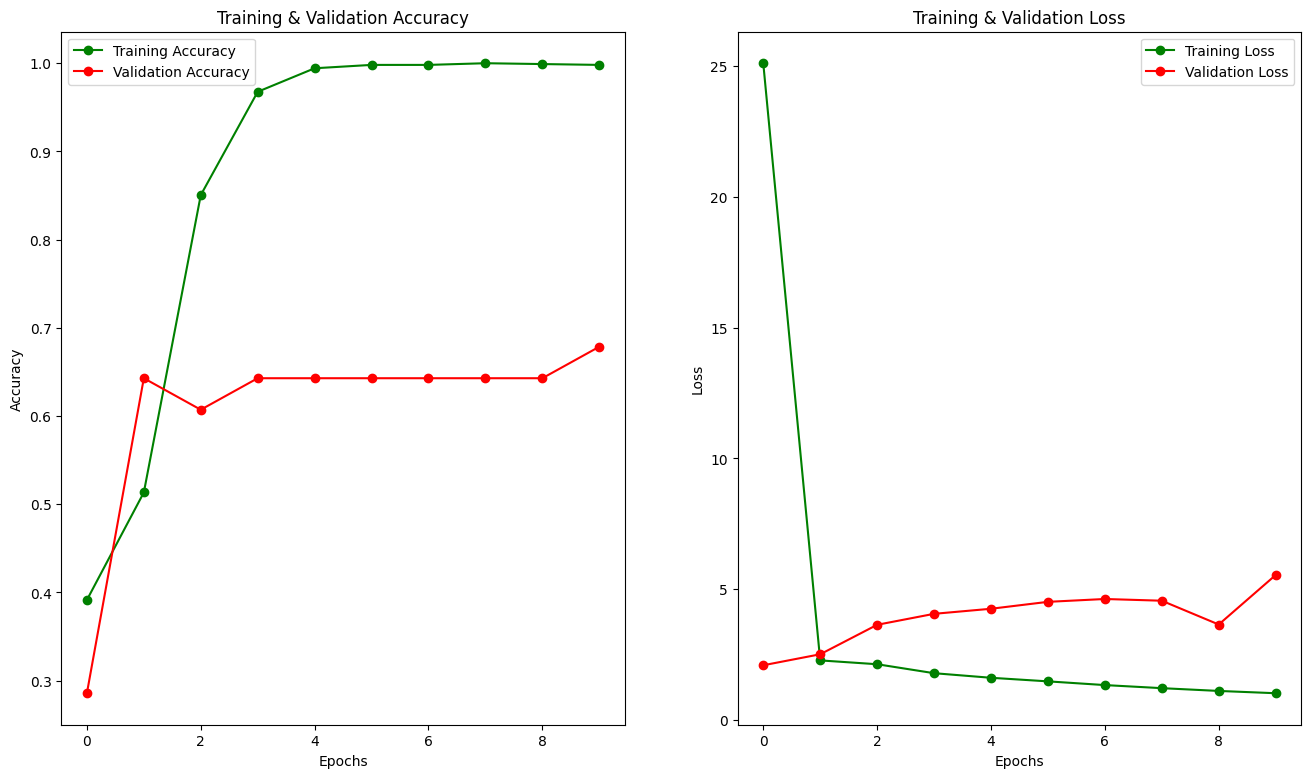

In [57]:
results_hyper = hypermodel.evaluate(test_generator)
vis_result(hist_hp, e=10)

In [19]:
hypermodel_2 = get_model()
hypermodel_2.compile(optimizer=Adam(0.01), loss='categorical_crossentropy', metrics=['accuracy'])
hypermodel_2.load_weights('./models/checkpoint.weights.h5')



e:\Programacion\IA\CNN\tf_gpu_env\Lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [28]:
hypermodel_2.evaluate(test_generator)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 156ms/step - accuracy: 0.6395 - loss: 4.1325


[4.127704620361328, 0.6388888955116272]

### Modelo final

In [42]:
def get_model():
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Conv2D(75, (3,3), activation='relu', input_shape=(124, 124, 1))),
    model.add(tf.keras.layers.MaxPooling2D(2, 2)),
    model.add(tf.keras.layers.Flatten()),
    model.add(tf.keras.layers.Dense(512, kernel_regularizer=regularizers.l2(1e-5), activation='relu')),
    model.add(tf.keras.layers.BatchNormalization()),
    model.add(tf.keras.layers.Dropout(0.2)),
    model.add(tf.keras.layers.Dense(128, kernel_regularizer=regularizers.l2(1e-5), activation='relu')),
    model.add(tf.keras.layers.BatchNormalization()),
    model.add(tf.keras.layers.Dropout(0.2)),
    model.add(tf.keras.layers.Dense(len(classes), activation='softmax'))

    return model

model = get_model()
model.summary()

model.compile(optimizer=Adam(0.001), loss='categorical_crossentropy', metrics=['accuracy'])

e:\Programacion\tumor-detection\env\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 122, 122, 75)   │           750 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 61, 61, 75)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 279075)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 512)            │   142,886,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 142,956,402 (545.34 MB)

 Trainable params: 142,955,122 (545.33 MB)

 Non-trainable params: 1,280 (5.00 KB)

In [43]:
hist = model.fit(train_generator, epochs=10, validation_data=validation_generator)

Epoch 1/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 224s 5s/step - accuracy: 0.6819 - loss: 0.9698 - val_accuracy: 0.3092 - val_loss: 3.8807
Epoch 2/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 120s 3s/step - accuracy: 0.8727 - loss: 0.4138 - val_accuracy: 0.6527 - val_loss: 0.8437
Epoch 3/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 130s 3s/step - accuracy: 0.9494 - loss: 0.2327 - val_accuracy: 0.6718 - val_loss: 1.3577
Epoch 4/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 128s 3s/step - accuracy: 0.9823 - loss: 0.1475 - val_accuracy: 0.8397 - val_loss: 0.5017
Epoch 5/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 132s 3s/step - accuracy: 0.9932 - loss: 0.1075 - val_accuracy: 0.8969 - val_loss: 0.3584
Epoch 6/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 128s 3s/step - accuracy: 0.9952 - loss: 0.0992 - val_accuracy: 0.6527 - val_loss: 1.3468
Epoch 7/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 127s 3s/step - accuracy: 0.9954 - loss: 0.0981 - val_accuracy: 0.8473 - val_loss: 0.5156
Epoch 8/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 127s 3s/step - accuracy: 0.9975 - loss: 0.0928 - val_accuracy: 0.9542 - v

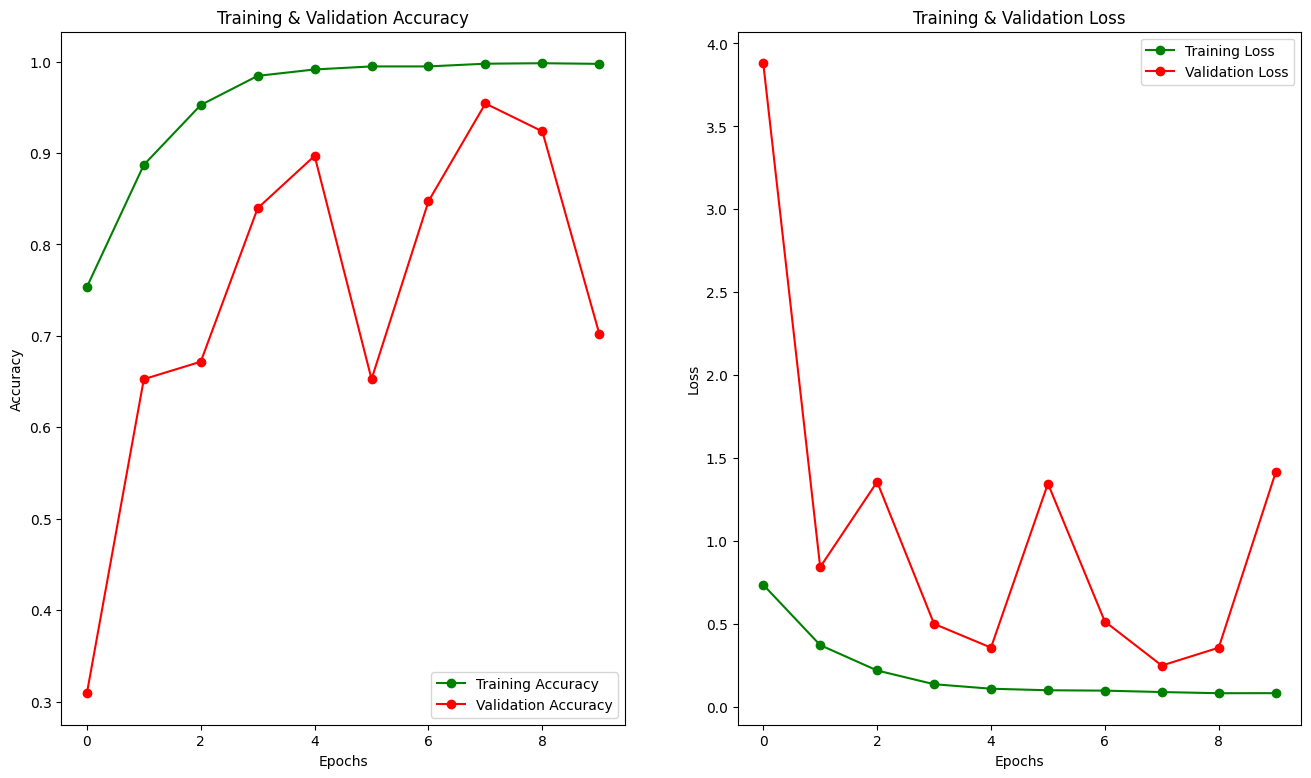

In [45]:
vis_result(hist, e=10)

In [62]:
preds = model.predict(predict_generator)
y_pred = np.argmax(preds, axis=1)

e:\Programacion\tumor-detection\env\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


In [73]:
pred_labels = np.argmax(preds, axis=1)

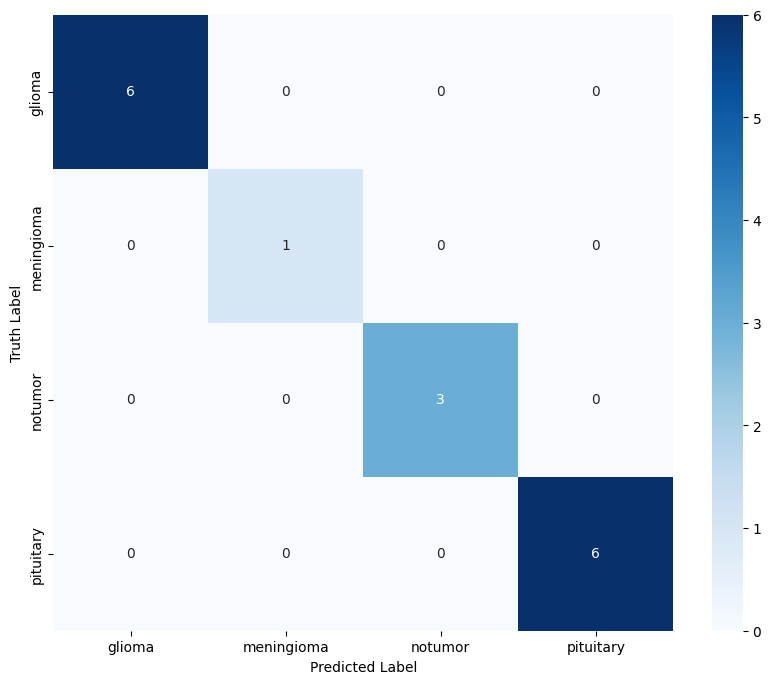

In [74]:
cm = confusion_matrix(pred_labels, y_pred)
labels = classes
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('Truth Label')
plt.show()